In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
%cd /content/drive/My Drive
df = pd.read_csv('train.csv', sep=';')

/content/drive/My Drive


Preprocessing Data Train

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


In [ ]:
df.describe()

,age,balance,day,duration,campaign,pdays,previous
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,1362.272058,15.806419,258.163080,2.763841,40.197828,0.580323
std,10.618762,3044.765829,8.322476,257.527812,3.098021,100.128746,2.303441
min,18.000000,-8019.000000,1.000000,0.000000,1.000000,-1.000000,0.000000
25%,33.000000,72.000000,8.000000,103.000000,1.000000,-1.000000,0.000000
50%,39.000000,448.000000,16.000000,180.000000,2.000000,-1.000000,0.000000
75%,48.000000,1428.000000,21.000000,319.000000,3.000000,-1.000000,0.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000,871.000000,275.000000


In [ ]:
df.head(5)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [ ]:
# pengelompokan kolom berdasarkan jenisnya
cats = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']
nums = ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous', 'y']

In [ ]:
df['y'] = df['y'].replace({'yes': 1 , 'no': 0})

<Axes: >

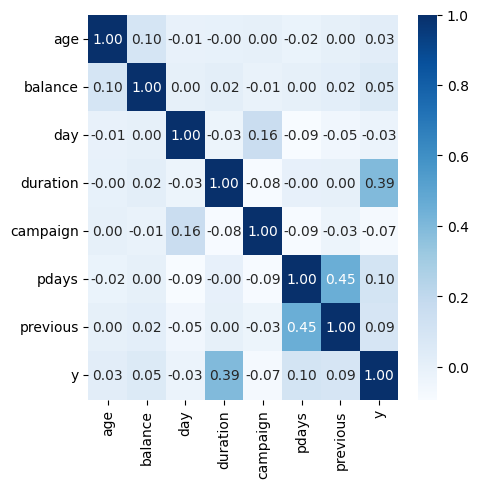

In [ ]:
plt.figure(figsize=(5, 5))
sns.heatmap(df[nums].corr(), cmap='Blues', annot=True, fmt='.2f')



*   Sejauh ini feature numeric yang digunakan adalah feature yang memiliki korelasi positif dengan target yaitu, age, balance, duration, pdays dan previous
*   Semua feature categorical akan digunakan.
*   Column 'y' merupakan target







In [ ]:
for col in cats:
    print(f'''Value count kolom {col}:''')
    print(df[col].value_counts())
    print()

Value count kolom job:
job
blue-collar      9732
management       9458
technician       7597
admin.           5171
services         4154
retired          2264
self-employed    1579
entrepreneur     1487
unemployed       1303
housemaid        1240
student           938
unknown           288
Name: count, dtype: int64

Value count kolom marital:
marital
married     27214
single      12790
divorced     5207
Name: count, dtype: int64

Value count kolom education:
education
secondary    23202
tertiary     13301
primary       6851
unknown       1857
Name: count, dtype: int64

Value count kolom default:
default
no     44396
yes      815
Name: count, dtype: int64

Value count kolom housing:
housing
yes    25130
no     20081
Name: count, dtype: int64

Value count kolom loan:
loan
no     37967
yes     7244
Name: count, dtype: int64

Value count kolom contact:
contact
cellular     29285
unknown      13020
telephone     2906
Name: count, dtype: int64

Value count kolom month:
month
may    13766
jul

**Handling Data Redundant**

a. Identifikasi fitur redundant:
- Numerical data: kolerasi *no multicollinearity*
- Categorical data: chi-square *all significant kecuali housing x default*


b. Feature selection/elimination
  - untuk housing dan default yang tidak significant pada saat dilakuakn chi-square, bisa dijadikan pertimbangan untuk di drop apabila model tidak bagus kedepannya, untuk sekarang tidak di drop dulu.

In [ ]:
corr_matrix = df[nums].corr().abs() #-> ini biar kita hitung nilai korelasi tanpa perhatiin dia korelasi positif atau korelasi negatif

batas_atas = 0.9

col_drop = set()
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if corr_matrix.iloc[i, j] > batas_atas:
            colname = corr_matrix.columns[i]
            col_drop.add(colname)

df = df.drop(columns=col_drop)

In [ ]:
from scipy.stats import chi2_contingency

def run_chi_square_tests(df, significance_level=0.05):
    # Identify categorical columns
    cat_columns = df[cats].columns

    # Store results
    results = []

    # Iterate through all pairs of categorical columns
    for i in range(len(cat_columns)):
        for j in range(i+1, len(cat_columns)):
            col1, col2 = cat_columns[i], cat_columns[j]

            # Create contingency table
            contingency_table = pd.crosstab(df[col1], df[col2])

            # Perform chi-square test
            chi2, p_value, dof, expected = chi2_contingency(contingency_table)

            # Check significance
            is_significant = p_value < significance_level

            # Store results
            results.append({
                'Column 1': col1,
                'Column 2': col2,
                'Chi-square': chi2,
                'p-value': p_value,
                'DoF': dof,
                'Significant': is_significant
            })

    # Convert results to DataFrame
    results_df = pd.DataFrame(results)
    return results_df


# Run chi-square tests
results = run_chi_square_tests(df)
print(results)

     Column 1   Column 2    Chi-square        p-value  DoF  Significant
0         job    marital   3837.602659   0.000000e+00   22         True
1         job  education  28483.136453   0.000000e+00   33         True
2         job    default     60.342533   8.008040e-09   11         True
3         job    housing   3588.730894   0.000000e+00   11         True
4         job       loan    512.810488  5.937325e-103   11         True
5         job    contact   2047.133177   0.000000e+00   22         True
6         job      month   6043.866403   0.000000e+00  121         True
7         job   poutcome    559.277767   6.111396e-97   33         True
8     marital  education   1337.509872  8.207754e-286    6         True
9     marital    default     16.719386   2.341162e-04    2         True
10    marital    housing     19.344820   6.299785e-05    2         True
11    marital       loan    121.952535   3.298705e-27    2         True
12    marital    contact    183.843074   1.114551e-38    4      

In [ ]:
from scipy.stats import chi2_contingency

# Job vs. y
job_y = pd.crosstab(df['job'], df['y'])
print("Job vs. y:\n", job_y)

# Perform chi-square test
chi2, p_value, dof, expected = chi2_contingency(job_y)

print(f"\nChi-square statistic: {chi2:.4f}")
print(f"p-value: {p_value:.4f}")
print(f"Degrees of freedom: {dof}")
print("\nExpected frequencies:")
print(expected)

Job vs. y:
 y                 0     1
job                      
admin.         4540   631
blue-collar    9024   708
entrepreneur   1364   123
housemaid      1131   109
management     8157  1301
retired        1748   516
self-employed  1392   187
services       3785   369
student         669   269
technician     6757   840
unemployed     1101   202
unknown         254    34

Chi-square statistic: 836.1055
p-value: 0.0000
Degrees of freedom: 11

Expected frequencies:
[[4566.0715755   604.9284245 ]
 [8593.5038818  1138.4961182 ]
 [1313.04359559  173.95640441]
 [1094.93884232  145.06115768]
 [8351.55771825 1106.44228175]
 [1999.14640242  264.85359758]
 [1394.28099356  184.71900644]
 [3668.04512176  485.95487824]
 [ 828.2682533   109.7317467 ]
 [6708.26643958  888.73356042]
 [1150.56879963  152.43120037]
 [ 254.30837628   33.69162372]]


In [ ]:
# Marital vs. y
marital_y = pd.crosstab(df['marital'], df['y'])
print("\nMarital vs. y:\n", marital_y)

# Perform chi-square test
chi2, p_value, dof, expected = chi2_contingency(marital_y)

print(f"\nChi-square statistic: {chi2:.4f}")
print(f"p-value: {p_value:.4f}")
print(f"Degrees of freedom: {dof}")
print("\nExpected frequencies:")
print(expected)


Marital vs. y:
 y             0     1
marital              
divorced   4585   622
married   24459  2755
single    10878  1912

Chi-square statistic: 196.4959
p-value: 0.0000
Degrees of freedom: 2

Expected frequencies:
[[ 4597.86012254   609.13987746]
 [24030.37552808  3183.62447192]
 [11293.76434938  1496.23565062]]


In [ ]:
# Education vs. y
education_y = pd.crosstab(df['education'], df['y'])
print("\nEducation vs. y:\n", education_y)

# Perform chi-square test
chi2, p_value, dof, expected = chi2_contingency(education_y)

print(f"\nChi-square statistic: {chi2:.4f}")
print(f"p-value: {p_value:.4f}")
print(f"Degrees of freedom: {dof}")
print("\nExpected frequencies:")
print(expected)


Education vs. y:
 y              0     1
education             
primary     6260   591
secondary  20752  2450
tertiary   11305  1996
unknown     1605   252

Chi-square statistic: 238.9235
p-value: 0.0000
Degrees of freedom: 3

Expected frequencies:
[[ 6049.5371038    801.4628962 ]
 [20487.71856407  2714.28143593]
 [11744.98511424  1556.01488576]
 [ 1639.75921789   217.24078211]]


In [ ]:
# Loan vs. y
loan_y = pd.crosstab(df['loan'], df['y'])
print("\nLoan vs. y:\n", loan_y)

# Perform chi-square test
chi2, p_value, dof, expected = chi2_contingency(loan_y)

print(f"\nChi-square statistic: {chi2:.4f}")
print(f"p-value: {p_value:.4f}")
print(f"Degrees of freedom: {dof}")
print("\nExpected frequencies:")
print(expected)


Loan vs. y:
 y         0     1
loan             
no    33162  4805
yes    6760   484

Chi-square statistic: 209.6170
p-value: 0.0000
Degrees of freedom: 1

Expected frequencies:
[[33525.4379244  4441.5620756]
 [ 6396.5620756   847.4379244]]


In [ ]:
# Housing vs. y
housing_y = pd.crosstab(df['housing'], df['y'])
print("\nHousing vs. y:\n", housing_y)

# Perform chi-square test
chi2, p_value, dof, expected = chi2_contingency(housing_y)

print(f"\nChi-square statistic: {chi2:.4f}")
print(f"p-value: {p_value:.4f}")
print(f"Degrees of freedom: {dof}")
print("\nExpected frequencies:")
print(expected)


Housing vs. y:
 y            0     1
housing             
no       16727  3354
yes      23195  1935

Chi-square statistic: 874.8224
p-value: 0.0000
Degrees of freedom: 1

Expected frequencies:
[[17731.82813917  2349.17186083]
 [22190.17186083  2939.82813917]]


In [ ]:
# Default vs. y
default_y = pd.crosstab(df['default'], df['y'])
print("\nDefault vs. y:\n", default_y)

# Perform chi-square test
chi2, p_value, dof, expected = chi2_contingency(default_y)

print(f"\nChi-square statistic: {chi2:.4f}")
print(f"p-value: {p_value:.4f}")
print(f"Degrees of freedom: {dof}")
print("\nExpected frequencies:")
print(expected)


Default vs. y:
 y            0     1
default             
no       39159  5237
yes        763    52

Chi-square statistic: 22.2022
p-value: 0.0000
Degrees of freedom: 1

Expected frequencies:
[[39202.34261574  5193.65738426]
 [  719.65738426    95.34261574]]


In [ ]:
# Contact vs. y
contact_y = pd.crosstab(df['contact'], df['y'])
print("\nContact vs. y:\n", contact_y)

# Perform chi-square test
chi2, p_value, dof, expected = chi2_contingency(contact_y)

print(f"\nChi-square statistic: {chi2:.4f}")
print(f"p-value: {p_value:.4f}")
print(f"Degrees of freedom: {dof}")
print("\nExpected frequencies:")
print(expected)


Contact vs. y:
 y              0     1
contact               
cellular   24916  4369
telephone   2516   390
unknown    12490   530

Chi-square statistic: 1035.7142
p-value: 0.0000
Degrees of freedom: 2

Expected frequencies:
[[25859.09999779  3425.90000221]
 [ 2566.04215788   339.95784212]
 [11496.85784433  1523.14215567]]


In [ ]:
# Month vs. y
month_y = pd.crosstab(df['month'], df['y'])
print("\nMonth vs. y:\n", month_y)

# Perform chi-square test
chi2, p_value, dof, expected = chi2_contingency(month_y)

print(f"\nChi-square statistic: {chi2:.4f}")
print(f"p-value: {p_value:.4f}")
print(f"Degrees of freedom: {dof}")
print("\nExpected frequencies:")
print(expected)


Month vs. y:
 y          0    1
month            
apr     2355  577
aug     5559  688
dec      114  100
feb     2208  441
jan     1261  142
jul     6268  627
jun     4795  546
mar      229  248
may    12841  925
nov     3567  403
oct      415  323
sep      310  269

Chi-square statistic: 3061.8389
p-value: 0.0000
Degrees of freedom: 11

Expected frequencies:
[[ 2589.00055296   342.99944704]
 [ 5516.19592577   730.80407423]
 [  188.96525182    25.03474818]
 [ 2339.10725266   309.89274734]
 [ 1238.87031917   164.12968083]
 [ 6088.3897724    806.6102276 ]
 [ 4716.18415872   624.81584128]
 [  421.19824821    55.80175179]
 [12155.58718011  1610.41281989]
 [ 3505.57032581   464.42967419]
 [  651.66521422    86.33478578]
 [  511.26579815    67.73420185]]


**Handling Missing Values**

Dari informasi value setiap kolom tidak ada kolom yang secara eksplisit memiliki nilai NaN (missing values), tetapi ada beberapa kolom yang memiliki nilai "unknown" yang mungkin perlu ditangani sebagai missing values.

Selanjutnya nilai unknown yang diproses mode hanya pada kolom job, education saja, pada kolom contact dan poutcome dipertahankan karena nilainya digunakan agar data tidak bias.

*demikian seingat saya dari hasil diskusi semalam, kalau ada koreksi boleh yaa.

*Kak, aku ada saran. Benar berdasarkan hasil diskusi terdapat 2 opsi kolom contact dan poutcome unknown values nya dapat dibiarkan agar tidak bias atau feature contact dan pendidikan dapat di drop saja. Mungkin pada stage ini dua kolom tersebut masih kita gunakan, namun perlu kita coba pada saat stage modeling, apakah hasilnya lebih bagus jika kolom ini dipertahankan atau di drop saja.

In [ ]:
df['education'].replace(['unknown'], df['education'].mode(),inplace = True)
df['job'].replace(['unknown'], df['job'].mode(),inplace = True)

Handling Duplicates

In [ ]:
duplicate_row = df[df.duplicated(keep=False)]
duplicate_row

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y


dengan code diatas, saya menemukan bahwa terdapat 1 data duplicate yang menurut saya tidak perlu di drop karena jumlahnya sangat sedikit dan tidak mempengaruhi dataset

Handling Outliers

Visualisasi Sebelum Menangani Outlier

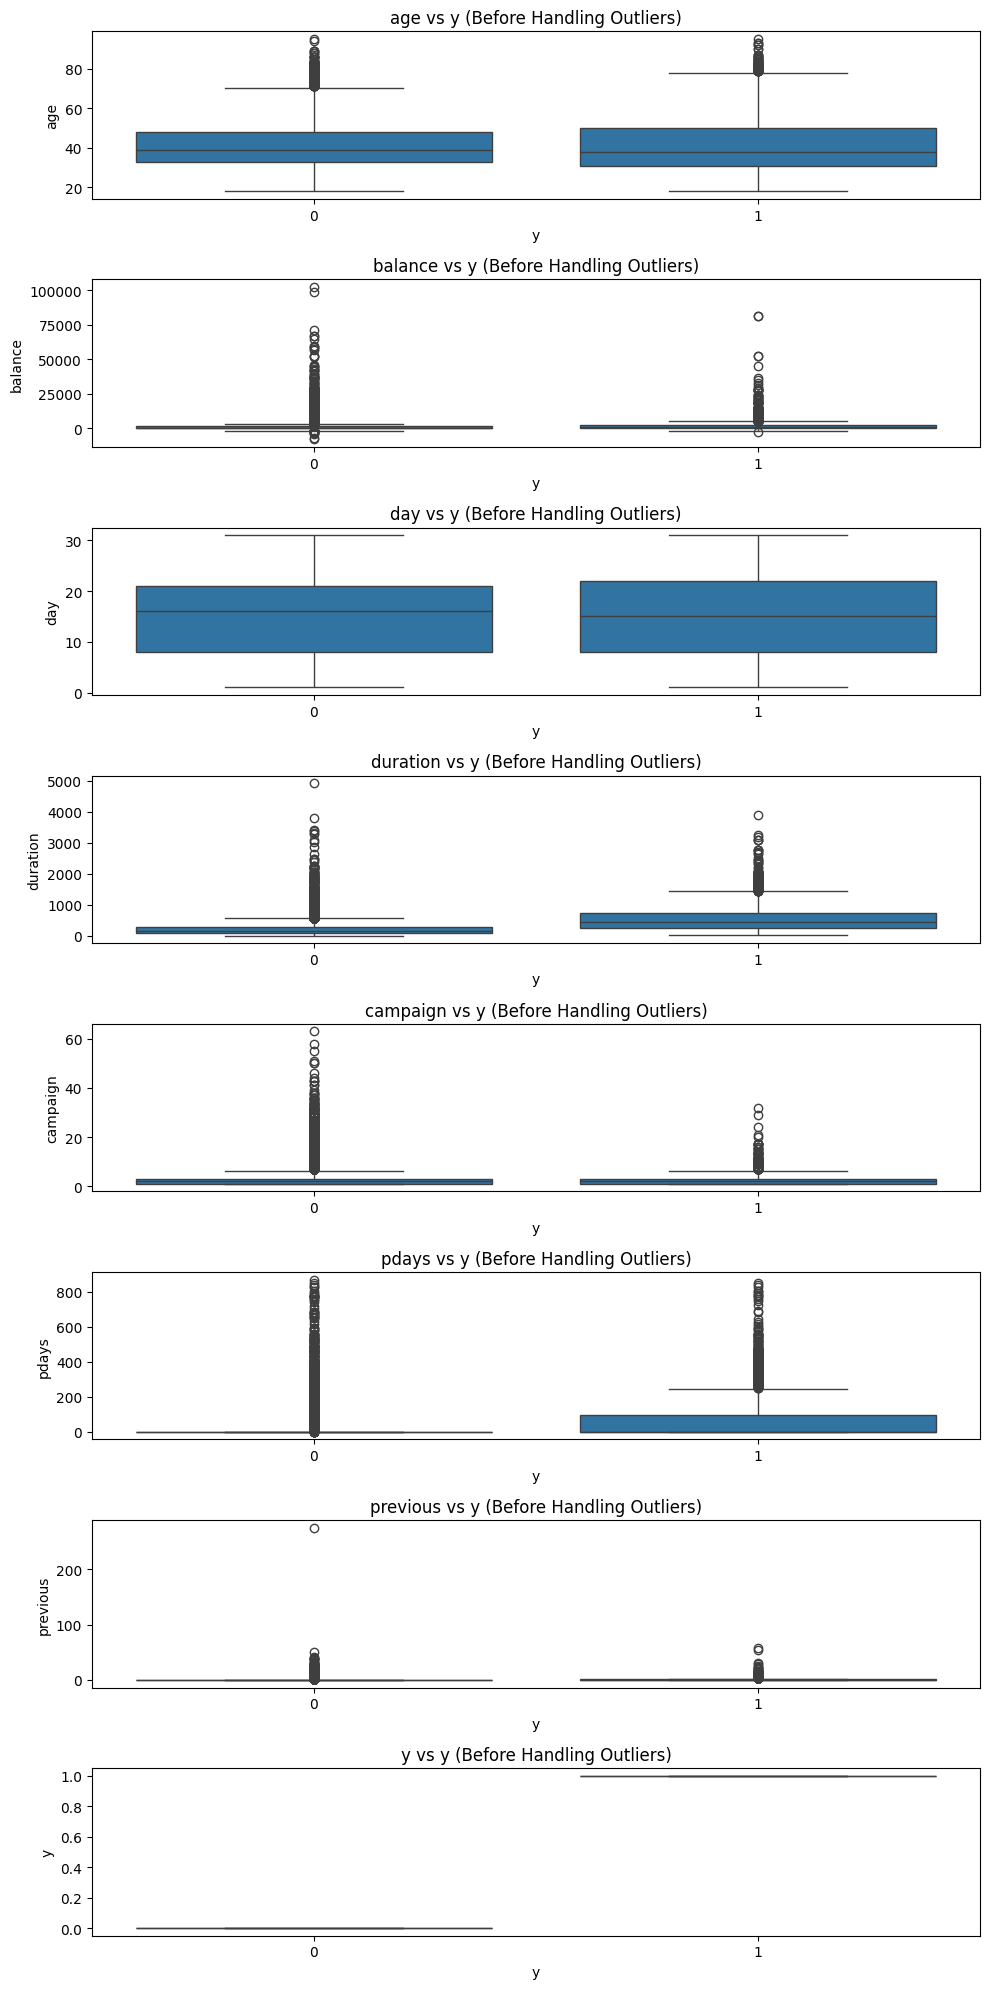

In [ ]:
fig, axes = plt.subplots(len(nums), 1, figsize=(10, 20))
for i, feature in enumerate(nums):
    sns.boxplot(x='y', y=feature, data=df, ax=axes[i])
    axes[i].set_title(f'{feature} vs y (Before Handling Outliers)')
plt.tight_layout()
plt.show()

Boxplot menampilkan distribusi data numerik dan memungkinkan identifikasi outlier sebagai titik-titik yang berada di luar "whiskers" dari boxplot. Ini memberikan pandangan awal tentang bagaimana distribusi fitur numerik terkait dengan variabel target y dan menunjukkan adanya outlier

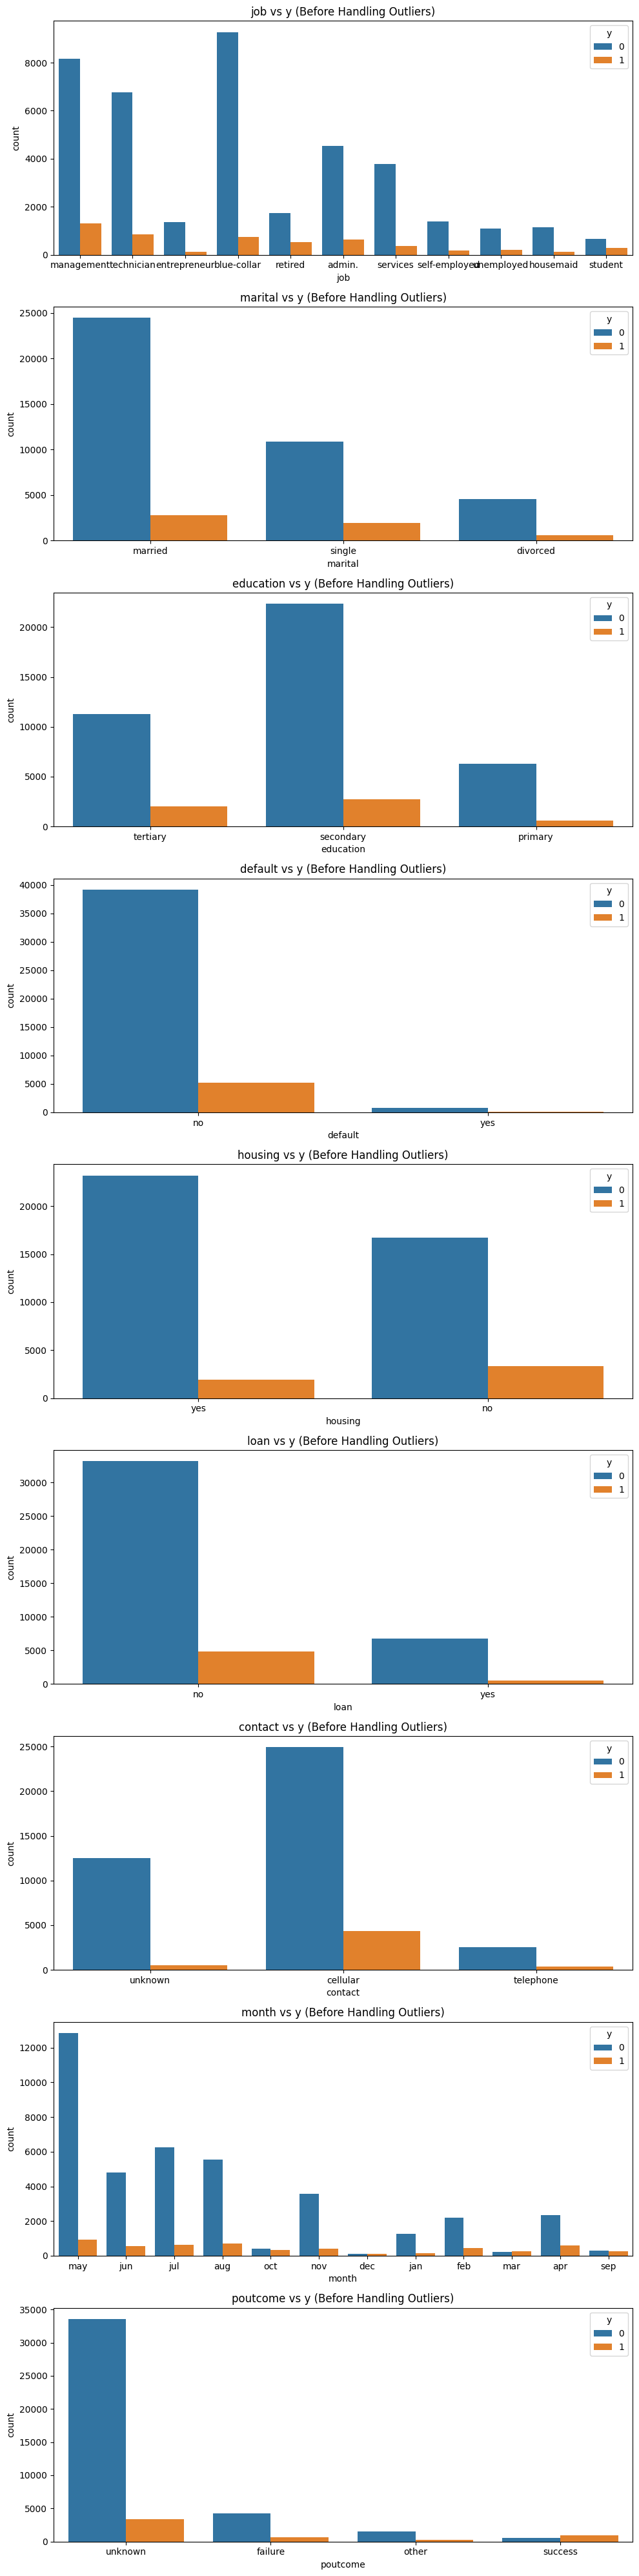

In [ ]:
fig, axes = plt.subplots(len(cats), 1, figsize=(10, 40))
for i, feature in enumerate(cats):
    sns.countplot(x=feature, hue='y', data=df, ax=axes[i])
    axes[i].set_title(f'{feature} vs y (Before Handling Outliers)')
    axes[i].legend(title='y', loc='upper right')
plt.tight_layout()
plt.show()

Countplot menampilkan distribusi fitur kategorikal dengan menghitung jumlah kemunculan setiap kategori, dibagi berdasarkan variabel target y. Ini membantu memahami bagaimana kategori dalam setiap fitur terkait dengan variabel target.

Mengidentifikasi dan Menghapus Outlier dengan IQR

In [ ]:
def remove_outliers_iqr(df, columns):
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    return df

#data_no_outliers_iqr = remove_outliers_iqr(data.copy(), numerical_features)

Bisa ditinjau lagi untuk menghapus outlier target 'y' dikeluarkan dari nums dahulu

Feature Encoding & Other Feature Engineering

In [ ]:
df['previous'] = df['previous'].apply(lambda x: 0 if x == 0 else 1)

In [ ]:
drop_columns = ['day', 'campaign']
df = df.drop(drop_columns, axis=1)

feature previous dan pdays memiliki arti deskripsi pada representasi nilai minimum nya sama, sehingga dilakukan feature engineering.

In [ ]:
def age_category(x):

    if x['age'] <= 16:
        age_category = 'Minor'
    elif x['age'] >= 17 and x['age'] <= 23:
         age_category = 'Young Adult 1'
    elif x['age'] >= 24 and x['age'] <= 30:
         age_category = 'Young Adult 2'
    elif x['age'] >= 31 and x['age'] <= 39:
         age_category = 'Middle Aged 1'
    elif x['age'] >= 40 and x['age'] <= 49:
         age_category = 'Middle Aged 2'
    elif x['age'] >= 50 and x['age'] <= 59:
         age_category = 'Middle Aged 3'
    else:
         age_category = 'Senior Citizen'
    return age_category

df['age'] = df.apply(lambda x: age_category(x), axis=1)

Melakukan grouping untuk mengurangi kompleksitas pada feature age.

In [ ]:
#Label Encoding

df['education'] = df['education'].replace({'primary': 2, 'secondary': 1, 'tertiary' : 0}).astype(int)
df['default'] = df['default'].replace({'yes': 1, 'no': 0})
df['housing'] = df['housing'].replace({'yes': 1, 'no': 0})
df['loan'] = df['loan'].replace({'yes': 1, 'no': 0})
df['age'] = df['age'].replace({'Minor': 0, 'Young Adult 1': 1, 'Young Adult 2': 2, 'Middle Aged 1': 3, 'Middle Aged 2': 4, 'Middle Aged 3': 5, 'Senior Citizen': 6 })

In [ ]:
#One Hot Encoding

df = pd.get_dummies(df, columns=['month', 'marital', 'job', 'contact', 'poutcome'], dtype = int)

In [ ]:
from sklearn.preprocessing import MinMaxScaler,StandardScaler
# Normalization
mms = MinMaxScaler()

# Standardization
ss = StandardScaler()

df['duration'] = ss.fit_transform(df[['duration']])
df['pdays'] = ss.fit_transform(df[['pdays']])
df['balance'] = ss.fit_transform(df[['balance']])
df['previous'] = ss.fit_transform (df[['previous']])



*   Categorical Feature  yang tidak memiliki sifat data ordinal, unique value lebih dari 2 dan missing value nya yang tidak dapat diisi pada data testing akan diberikan action one hot encoding.






Feature Transformation



*   Apakah lebih baik melakukan minmax scalling, standard atau melakukan log transformation ? Berdasarkan hasil diskusi tidak perlu dilakukan



handling imbalance class dengan SMOTE

In [ ]:
X_train = df.drop('y', axis=1)
y_train = df['y']
# 'y' sebelum smote
print("Distribusi target 'y' sebelum smote")
print(y_train.value_counts())


from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=1)
X_train, y_train = smote.fit_resample(X_train, y_train)


# 'y' setelah smote
print("Distribusi target 'y' setelah smote:")
print(y_train.value_counts())  # This will likely show a more balanced distribution

Distribusi target 'y' sebelum smote
y
0    39922
1     5289
Name: count, dtype: int64
Distribusi target 'y' setelah smote:
y
0    39922
1    39922
Name: count, dtype: int64


Feature Encoding & Other Feature Engineering on Data Testing

In [ ]:
%cd /content/drive/My Drive
df_testing = pd.read_csv('test.csv', sep=';')

/content/drive/My Drive


In [ ]:
df_testing['y'] = df_testing['y'].replace({'yes': 1 , 'no': 0})

In [ ]:
for col in cats:
    print(f'''Value count kolom {col}:''')
    print(df_testing[col].value_counts())
    print()

Value count kolom job:
job
management       969
blue-collar      946
technician       768
admin.           478
services         417
retired          230
self-employed    183
entrepreneur     168
unemployed       128
housemaid        112
student           84
unknown           38
Name: count, dtype: int64

Value count kolom marital:
marital
married     2797
single      1196
divorced     528
Name: count, dtype: int64

Value count kolom education:
education
secondary    2306
tertiary     1350
primary       678
unknown       187
Name: count, dtype: int64

Value count kolom default:
default
no     4445
yes      76
Name: count, dtype: int64

Value count kolom housing:
housing
yes    2559
no     1962
Name: count, dtype: int64

Value count kolom loan:
loan
no     3830
yes     691
Name: count, dtype: int64

Value count kolom contact:
contact
cellular     2896
unknown      1324
telephone     301
Name: count, dtype: int64

Value count kolom month:
month
may    1398
jul     706
aug     633
jun     

Karena jumlah missing value pada feature job dan education sangat minim masih dibawah 5%, maka kami tetap memutuskan untuk mengisi missing value tersebut dengan nilai mode nya.

In [ ]:
df_testing['education'].replace(['unknown'], df_testing['education'].mode(),inplace = True)
df_testing['job'].replace(['unknown'], df_testing['job'].mode(),inplace = True)

In [ ]:
df_testing['previous'] = df_testing['previous'].apply(lambda x: 0 if x == 0 else 1)

In [ ]:
drop_columns = ['day', 'campaign']
df_testing = df_testing.drop(drop_columns, axis=1)

In [ ]:
def age_category(x):

    if x['age'] <= 16:
        age_category = 'Minor'
    elif x['age'] >= 17 and x['age'] <= 23:
         age_category = 'Young Adult 1'
    elif x['age'] >= 24 and x['age'] <= 30:
         age_category = 'Young Adult 2'
    elif x['age'] >= 31 and x['age'] <= 39:
         age_category = 'Middle Aged 1'
    elif x['age'] >= 40 and x['age'] <= 49:
         age_category = 'Middle Aged 2'
    elif x['age'] >= 50 and x['age'] <= 59:
         age_category = 'Middle Aged 3'
    else:
         age_category = 'Senior Citizen'
    return age_category

df_testing['age'] = df_testing.apply(lambda x: age_category(x), axis=1)

In [ ]:
#Label Encoding

df_testing['education'] = df_testing['education'].replace({'primary': 2, 'secondary': 1, 'tertiary' : 0}).astype(int)
df_testing['default'] = df_testing['default'].replace({'yes': 1, 'no': 0})
df_testing['housing'] = df_testing['housing'].replace({'yes': 1, 'no': 0})
df_testing['loan'] = df_testing['loan'].replace({'yes': 1, 'no': 0})
df_testing['age'] = df_testing['age'].replace({'Minor': 0, 'Young Adult 1': 1, 'Young Adult 2': 2, 'Middle Aged 1': 3, 'Middle Aged 2': 4, 'Middle Aged 3': 5, 'Senior Citizen': 6 })

In [ ]:
#One Hot Encoding

df_testing = pd.get_dummies(df_testing, columns=['month', 'marital', 'job', 'contact', 'poutcome'], dtype = int)

In [ ]:
# Normalization
mms = MinMaxScaler()

# Standardization
ss = StandardScaler()

df_testing['duration'] = ss.fit_transform(df_testing[['duration']])
df_testing['pdays'] = ss.fit_transform(df_testing[['pdays']])
df_testing['balance'] = ss.fit_transform(df_testing[['balance']])
df_testing['previous'] = ss.fit_transform(df_testing[['previous']])

In [ ]:
X_test = df_testing.drop('y', axis=1)
y_test = df_testing['y']

Notes :

Tindakan selanjutnya pada data preprocessing jika hasil evaluasi model masih kurang baik

*   Melakukan grouping pada feature balance = 'negative balance' 'low balance' 'mid balance' and 'high balance'.
*   Drop feature poutcome dan contact karena nilai 'unknown' nya lebih dari 1/3 total data.
*   Pertimbangkan kembali method dalam pengisian missing value di sejumlah feature. Apakah dengan tetap menggunakan mode namun melihat hubungan nya dengan feature lain, menghilangkan row nya atau melakukan drop.
*   Diskusikan kembali feature yang akan digunakan.





In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
from sklearn.model_selection import cross_validate

def eval_classification(model):
    y_pred = model.predict(X_test)
    y_pred_train = model.predict(X_train)
    y_pred_proba = model.predict_proba(X_test)
    y_pred_proba_train = model.predict_proba(X_train)

    print("Accuracy (Test Set): %.2f" % accuracy_score(y_test, y_pred))
    print("Accuracy (Train Set): %.2f" % accuracy_score(y_train, y_pred_train))
    print("Recall (Test Set): %.2f" % recall_score(y_test, y_pred))
    print("Recall (Train Set): %.2f" % recall_score(y_train, y_pred_train))
    print("F1-Score (Test Set): %.2f" % f1_score(y_test, y_pred))
    print("F1-Score (Train Set): %.2f" % f1_score(y_train, y_pred_train))


    print("roc_auc (test-proba): %.2f" % roc_auc_score(y_test, y_pred_proba[:, 1]))
    print("roc_auc (train-proba): %.2f" % roc_auc_score(y_train, y_pred_proba_train[:, 1]))
    #
    score = cross_validate(model, X_train, y_train, cv=5, scoring='recall', return_train_score=True)
    print('recall (crossval train): '+ str(score['train_score'].mean()))
    print('recall (crossval test): '+ str(score['test_score'].mean()))

## Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import  accuracy_score, classification_report
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

In [ ]:
eval_classification(logreg)

Accuracy (Test Set): 0.87
Accuracy (Train Set): 0.89
Recall (Test Set): 0.63
Recall (Train Set): 0.88
F1-Score (Test Set): 0.54
F1-Score (Train Set): 0.89
roc_auc (test-proba): 0.88
roc_auc (train-proba): 0.96
recall (crossval train): 0.8851009703878525
recall (crossval test): 0.8687413054035436


Model secara keseluruhan dinilai kurang bagus berbanding dengan random forest dan xgboost dilihat dari nilai metrics seperti accuracy, recall, dan f1 score.

## Random Forest Classifier & Hyperparameter Tuning (RandomizedSearch)

In [ ]:
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)
y_pred = rf_classifier.predict(X_test)

In [ ]:
eval_classification(rf_classifier)

Accuracy (Test Set): 0.98
Accuracy (Train Set): 1.00
Recall (Test Set): 0.94
Recall (Train Set): 1.00
F1-Score (Test Set): 0.90
F1-Score (Train Set): 1.00
roc_auc (test-proba): 0.99
roc_auc (train-proba): 1.00
recall (crossval train): 0.9999874753420798
recall (crossval test): 0.9604968735216206


Skor 1.0, yang berarti model bekerja dengan sempurna pada data yang digunakan untuk data train,

Hasil pada dataset tes lebih rendah daripada pada set train, Ini menunjukkan bahwa model mungkin overfitting pada data train.

Overfitting : masalah pemodelan yang terjadi ketika model menghafal data train terlalu baik dan berkinerja buruk pada data yang tidak terlihat pada data test.



In [ ]:
importances_rf = rf_classifier.feature_importances_

In [ ]:
rf_classifier1 = RandomForestClassifier(n_estimators=100, max_depth=5, min_samples_split=20)
rf_classifier1.fit(X_train, y_train)
y_predrf1 = rf_classifier1.predict(X_test)

In [ ]:
eval_classification(rf_classifier1)

Accuracy (Test Set): 0.82
Accuracy (Train Set): 0.85
Recall (Test Set): 0.79
Recall (Train Set): 0.89
F1-Score (Test Set): 0.50
F1-Score (Train Set): 0.86
roc_auc (test-proba): 0.88
roc_auc (train-proba): 0.92
recall (crossval train): 0.8782625432416726
recall (crossval test): 0.8728518025405853


This model shows better balance between train and test performance, indicating better generalization.

In [ ]:
# Set hyperparameters to potentially reduce overfitting (adjustments are minor)
rf_classifier2 = RandomForestClassifier(n_estimators=80, max_depth=4, min_samples_split=15)
rf_classifier2.fit(X_train, y_train)
y_predrf2 = rf_classifier2.predict(X_test)

In [ ]:
eval_classification(rf_classifier2)

Accuracy (Test Set): 0.81
Accuracy (Train Set): 0.82
Recall (Test Set): 0.73
Recall (Train Set): 0.83
F1-Score (Test Set): 0.48
F1-Score (Train Set): 0.82
roc_auc (test-proba): 0.86
roc_auc (train-proba): 0.90
recall (crossval train): 0.8551425233463764
recall (crossval test): 0.8496061408979511


This model is similar to Model 2 but with slightly lower performance across most metrics.


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

# Define a dictionary of hyperparameter values to search over
param_grid = {
    'n_estimators': [50, 80, 100, 120],  # Range of number of trees
    'max_depth': [3, 4, 5, 6],  # Range of maximum tree depth
    'min_samples_split': [15, 20, 25]  # Range of minimum samples to split a node
}

# Set up the Random Forest model
rf_classifier = RandomForestClassifier()

# Initialize GridSearchCV with cross-validation
grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, cv=5, scoring='recall')

# Train the model with GridSearchCV
grid_search.fit(X_train, y_train)

# Get the best model with the best hyperparameters
best_rf_model = grid_search.best_estimator_

# Make predictions on the test set using the best model
y_pred_best_rf = best_rf_model.predict(X_test)

# Evaluate the performance of the best model (you can use your custom function)
eval_classification(best_rf_model)

Accuracy (Test Set): 0.82
Accuracy (Train Set): 0.86
Recall (Test Set): 0.81
Recall (Train Set): 0.90
F1-Score (Test Set): 0.51
F1-Score (Train Set): 0.86
roc_auc (test-proba): 0.89
roc_auc (train-proba): 0.92
recall (crossval train): 0.8946821250702153
recall (crossval test): 0.886703409950772


This model, optimized through GridSearchCV, shows a good balance of performance metrics and generalization.

## XGBoost & Hyperparameter Tuning (RandomizedSearch)

In [ ]:
import xgboost as xgb

xgb_model = xgb.XGBClassifier()
xgb_model.fit(X_train, y_train)
y_predxgb = xgb_model.predict(X_test)

In [ ]:
eval_classification(xgb_model)

Accuracy (Test Set): 0.90
Accuracy (Train Set): 0.94
Recall (Test Set): 0.83
Recall (Train Set): 0.96
F1-Score (Test Set): 0.66
F1-Score (Train Set): 0.94
roc_auc (test-proba): 0.95
roc_auc (train-proba): 0.99
recall (crossval train): 0.9603727325334379
recall (crossval test): 0.9291848380543177


In [ ]:
from sklearn.model_selection import RandomizedSearchCV

#Menjadikan ke dalam bentuk dictionary
hyperparameters = {
                    'max_depth' : [int(x) for x in np.linspace(10, 110, num = 11)],
                    'min_child_weight' : [int(x) for x in np.linspace(1, 20, num = 11)],
                    'gamma' : [float(x) for x in np.linspace(0, 1, num = 11)],
                    'tree_method' : ['auto', 'exact', 'approx', 'hist'],

                    'colsample_bytree' : [float(x) for x in np.linspace(0, 1, num = 11)],
                    'eta' : [float(x) for x in np.linspace(0, 1, num = 100)],

                    'lambda' : [float(x) for x in np.linspace(0, 1, num = 11)],
                    'alpha' : [float(x) for x in np.linspace(0, 1, num = 11)]
                    }

# Init
from xgboost import XGBClassifier
xg = XGBClassifier(random_state=42)
xg_tuned_random = RandomizedSearchCV(xg, hyperparameters, cv=5, random_state=42, scoring='recall')
xg_tuned_random.fit(X_train,y_train)

# Predict & Evaluation
eval_classification(xg_tuned_random)

Accuracy (Test Set): 0.94
Accuracy (Train Set): 0.98
Recall (Test Set): 0.85
Recall (Train Set): 0.99
F1-Score (Test Set): 0.75
F1-Score (Train Set): 0.98
roc_auc (test-proba): 0.97
roc_auc (train-proba): 1.00
recall (crossval train): 0.9777125761320369
recall (crossval test): 0.9264798444729158


In [ ]:
best_model_xg = xg_tuned_random.best_estimator_

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

# Hyperparameters with focus on overfitting reduction (adjust search ranges as needed)
hyperparameters = {
    'max_depth': [int(x) for x in np.linspace(3, 6, num=4)],  # Reduced search range
    'min_child_weight': [int(x) for x in np.linspace(4, 10, num=7)],  # Adjusted range
    'gamma': [float(x) for x in np.linspace(0.1, 0.5, num=5)],  # Higher gamma values
    'tree_method': ['approx', 'hist'],  # Exclude 'exact' and 'auto' for efficiency
    'colsample_bytree': [float(x) for x in np.linspace(0.7, 1, num=4)],  # Higher subsampling
    'eta': [float(x) for x in np.linspace(0.001, 0.1, num=10)],  # Lower learning rate range
    'lambda': [float(x) for x in np.linspace(1, 2, num=4)],  # Higher L2 penalty
    'alpha': [0]  # No L1 penalty
}

# Init
from xgboost import XGBClassifier
xg = XGBClassifier(random_state=42)
xg_tuned_overfitting = RandomizedSearchCV(xg, hyperparameters, cv=5, random_state=42)
xg_tuned_overfitting.fit(X_train, y_train)

# Predict & Evaluation
eval_classification(xg_tuned_overfitting)

Accuracy (Test Set): 0.81
Accuracy (Train Set): 0.85
Recall (Test Set): 0.80
Recall (Train Set): 0.90
F1-Score (Test Set): 0.49
F1-Score (Train Set): 0.86
roc_auc (test-proba): 0.89
roc_auc (train-proba): 0.93
recall (crossval train): 0.9385613421366644
recall (crossval test): 0.9221975604308177


## Feature Importance

In [ ]:
feature_importances = pd.DataFrame({
    'feature': X_test.columns,
    'importance': importances_rf
})


feature_importances = feature_importances.sort_values('importance', ascending=False).reset_index(drop=True)

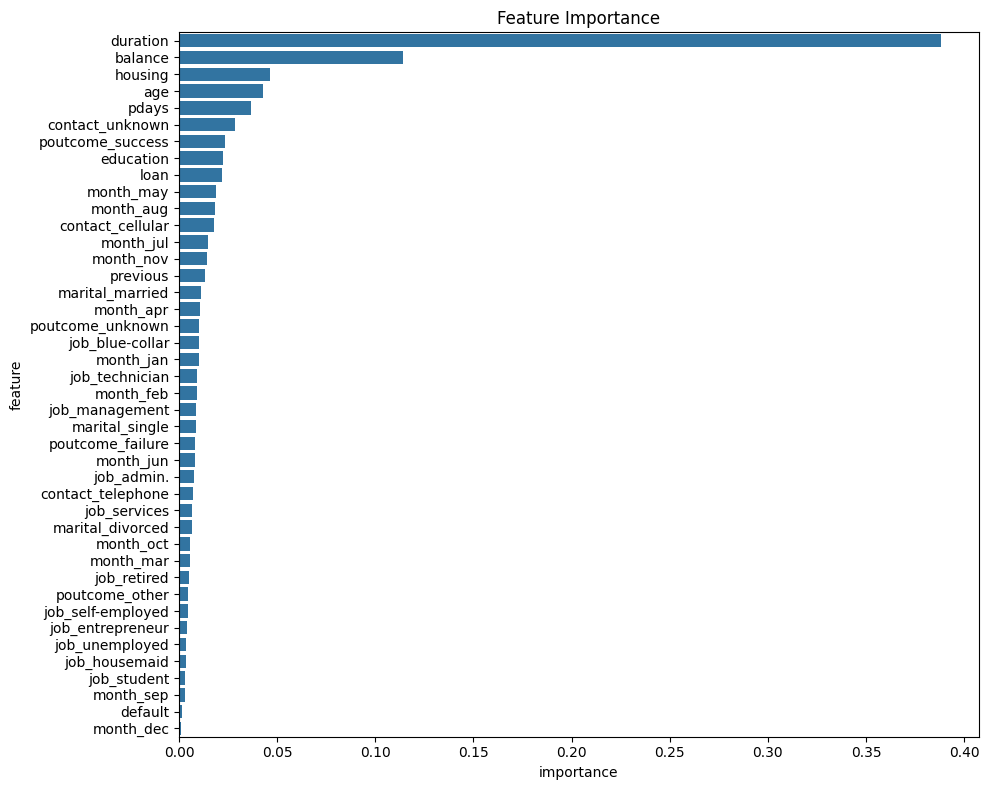

In [ ]:
plt.figure(figsize=(10, 8))
sns.barplot(x='importance', y='feature', data=feature_importances.sort_values('importance', ascending=False))
plt.title('Feature Importance')
plt.tight_layout()
plt.show()

In [ ]:
bins = [0] + list(np.quantile(feature_importances['importance'], [0.25, 0.5, 0.75])) + [1]
labels = ['Low', 'Medium-Low', 'Medium-High', 'High']

# Add bin column
feature_importances['importance_bin'] = pd.cut(feature_importances['importance'], bins=bins, labels=labels, include_lowest=True)

# Display results
print(feature_importances)

              feature  importance importance_bin
0            duration    0.388004           High
1             balance    0.113956           High
2             housing    0.046432           High
3                 age    0.042606           High
4               pdays    0.036658           High
5     contact_unknown    0.028521           High
6    poutcome_success    0.023445           High
7           education    0.022263           High
8                loan    0.022026           High
9           month_may    0.018939           High
10          month_aug    0.018492           High
11   contact_cellular    0.017807    Medium-High
12          month_jul    0.014949    Medium-High
13          month_nov    0.014493    Medium-High
14           previous    0.013063    Medium-High
15    marital_married    0.011348    Medium-High
16          month_apr    0.010809    Medium-High
17   poutcome_unknown    0.010320    Medium-High
18    job_blue-collar    0.010300    Medium-High
19          month_ja

In [ ]:
bin_counts = feature_importances['importance_bin'].value_counts().sort_index()
print("\nNumber of features in each bin:")
print(bin_counts)


Number of features in each bin:
importance_bin
Low            11
Medium-Low     10
Medium-High    10
High           11
Name: count, dtype: int64


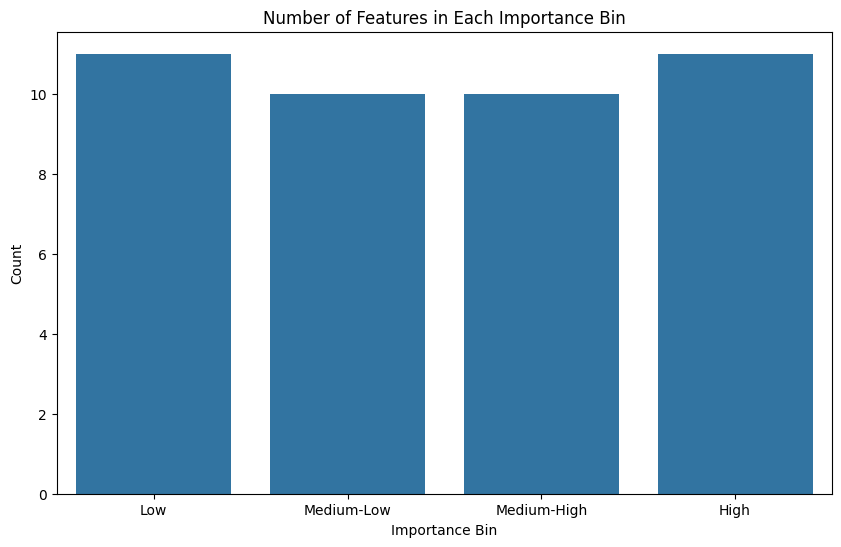

In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(x='importance_bin', data=feature_importances, order=['Low', 'Medium-Low', 'Medium-High', 'High'])
plt.title('Number of Features in Each Importance Bin')
plt.xlabel('Importance Bin')
plt.ylabel('Count')
plt.show()

In [ ]:
# Group the features by their importance bins
grouped = feature_importances.groupby('importance_bin')['feature'].apply(list).reset_index()

# Sort the bins in descending order of importance
bin_order = ['High', 'Medium-High', 'Medium-Low', 'Low']
grouped = grouped.set_index('importance_bin').loc[bin_order].reset_index()

# Create a DataFrame to display the results
result_table = pd.DataFrame({
    'Importance Bin': grouped['importance_bin'],
    'Features': grouped['feature'].apply(lambda x: ', '.join(x)),
    'Count': grouped['feature'].apply(len)
})

# Display the table
print(result_table.to_string(index=False))

from prettytable import PrettyTable

table = PrettyTable()
table.field_names = ["Importance Bin", "Features", "Count"]
for _, row in result_table.iterrows():
    table.add_row(row.tolist())

print(table)

Importance Bin                                                                                                                                               Features  Count
          High                                       duration, balance, housing, age, pdays, contact_unknown, poutcome_success, education, loan, month_may, month_aug     11
   Medium-High             contact_cellular, month_jul, month_nov, previous, marital_married, month_apr, poutcome_unknown, job_blue-collar, month_jan, job_technician     10
    Medium-Low       month_feb, job_management, marital_single, poutcome_failure, month_jun, job_admin., contact_telephone, job_services, marital_divorced, month_oct     10
           Low month_mar, job_retired, poutcome_other, job_self-employed, job_entrepreneur, job_unemployed, job_housemaid, job_student, month_sep, default, month_dec     11
+----------------+---------------------------------------------------------------------------------------------------------------------